# Clasificación KNN

#### Librerias a ser utilizadas en el proyecto

In [2]:
# Librerias para crear los vectores de caracteristicas
import os
import cv2
import pickle
import numpy as np
import pywt
# Liberias para crear el modelo de clasificacion
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_score,confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

Código para leer la data una vez y guardarlo en un archivo para no ejecutar el codigo a cada rato

In [56]:
def preprocess_and_extract_features(input_path, num_levels=1, target_size=(256, 256)):
    # Obtener la lista de imágenes en el directorio de entrada
    images = os.listdir(input_path)
    
    # Inicializar listas para almacenar características y etiquetas
    features_list = []
    labels = []
    
    for image_name in images:
        # Cargar la imagen usando OpenCV
        image_path = os.path.join(input_path, image_name)
        imagen = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Redimensionar la imagen y extraer características
        imagen = cv2.resize(imagen, target_size, interpolation=cv2.INTER_LANCZOS4)
        features = extract_features(imagen, num_levels)
        
        # Agregar características y etiqueta a las listas
        features_list.append(features)
        labels.append(image_name[:3])
    
    return features_list, labels

def extract_features(image, num_levels=1):
    # Realizar la transformación Wavelet
    LL = image.copy()
    for _ in range(num_levels):
        LL, (LH, HL, HH) = pywt.dwt2(LL, 'haar')
        LL = np.max(LL, axis=0)
        LH = np.max(LH, axis=0)
        HL = np.max(HL, axis=0)
        HH = np.max(HH, axis=0)
        LL = np.concatenate((LL, LH, HL, HH))
    
    # Normalizar las características al rango [0, 1]
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(LL.reshape(-1, 1)).flatten()
    
    return features_normalized

In [57]:
# Directorios de entrada y salida
path_images = 'images/'
path_save = 'images_save/'

# Obtener características independientes y etiquetas
indep, labels = preprocess_and_extract_features(path_images, num_levels=1, target_size=(256, 256))

# Normalizar las características independientes
scaler = MinMaxScaler()
indep_normalized = [scaler.fit_transform(feature.reshape(-1, 1)).flatten() for feature in indep]

# Combinar etiquetas y características independientes en un diccionario
dataset = {'labels': labels, 'indep': indep_normalized}

# Nombre del archivo para guardar el dataset
output_file = 'dataset.pkl'

# Guardar el dataset en un archivo utilizando pickle
with open(output_file, 'wb') as file:
    pickle.dump(dataset, file)

#### Modelo de clasificación KNN

Para empezar la clasificion KNN en la dataset Mariposas primero lo implementaremos con un k que pertenece entre [1-20] donde más adelante validaremos cual k es el mejor para la dataset.

#### Distancia Euclidiana

$d(x^{[a]}, x^{[b]}) = \sqrt{\sum_{j=1}^{m}(x^{[a]}, x^{[b]})^{2}}$

In [7]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

#### Función de predicción

In [6]:
def knn_multiple(x_train, y_train, x_tests, k=7):
    predictions = []
    for x_test in x_tests:
        distances = []
        for i in range(len(x_train)):
            distance = euclidean_distance(x_train[i], x_test)
            distances.append((distance, y_train[i]))
        distances = sorted(distances)
        targets = [distances[i][1] for i in range(k)]
        predictions.append(max(set(targets), key=targets.count))
    return predictions

### Entrenamiento con el modelo KNN

In [5]:
# Leemos las imagenes de las mariposas y las guardamos en un pickle
with open('dataset.pkl', 'rb') as file:
    dataset = pickle.load(file)
index = np.arange(len(dataset['labels']))
rnd = np.random.RandomState(123)
suffle_index = rnd.permutation(index)

Ponemos de manera aleatoria los datos.

In [8]:
x_shuffle, y_shuffle = [], []
for i in range(len(suffle_index)):
    x_shuffle.append(dataset['indep'][suffle_index[i]])
    y_shuffle.append(dataset['labels'][suffle_index[i]])
x_shuffle = np.array(x_shuffle)
y_shuffle = np.array(y_shuffle)

Separamos la data en 70% para entrenamiento, 15% para validacion y 15% para test

In [9]:
train_size = int(len(x_shuffle) * 0.70)
test_size = int(len(x_shuffle) * 0.15)
val_size = int(len(x_shuffle) * 0.15)

# Dividimos el dataset en train, test y validation
x_train = x_shuffle[:train_size]
y_train = y_shuffle[:train_size]

x_test = x_shuffle[train_size:train_size + test_size]
y_test = y_shuffle[train_size:train_size + test_size]

x_val = x_shuffle[train_size + test_size:]
y_val = y_shuffle[train_size + test_size:]

#### Metodo K-Fold Cross Validation

##### Cálculo de la presicion, recall y f1-score junto a un rango de K desde [1-20]

In [10]:
partitions = 15  # Cantidad de particiones
partitions_size = len(x_train) // partitions  # Tamaño de cada partición
performance_metrics = []
recall_metrics = []
f1_metrics = []

for k in range(1, 21):
    performance_metrics.append([])
    recall_metrics_k = []  # Lista para almacenar los recalls en esta iteración de k
    f1_metrics_k = []  # Lista para almacenar los F1-scores en esta iteración de k
    
    for i in range(partitions):
        # Particionamos el dataset de entrenamiento en 5 partes
        x_train_part = np.concatenate((x_train[:i * partitions_size], x_train[(i + 1) * partitions_size:]))
        y_train_part = np.concatenate((y_train[:i * partitions_size], y_train[(i + 1) * partitions_size:]))
        
        # Predecimos las etiquetas de las imágenes de validación
        y_pred = knn_multiple(x_train_part, y_train_part, x_val, k)
        
        # Calculamos la precisión de las predicciones
        accuracy = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        performance_metrics[k - 1].append(accuracy)
        
        # Calculamos el recall y el F1-score
        recall = recall_score(y_val, y_pred, average='weighted')
        f1 = f1_score(y_val, y_pred, average='weighted')
        recall_metrics_k.append(recall)
        f1_metrics_k.append(f1)
        
    # Calculamos la precisión promedio de las predicciones
    performance_metrics[k - 1] = np.mean(performance_metrics[k - 1])
    
    # Calculamos el recall promedio y el F1-score promedio
    recall_metrics.append(np.mean(recall_metrics_k))
    f1_metrics.append(np.mean(f1_metrics_k))


#### Gráfica de la presición, error, recall y F1-Score

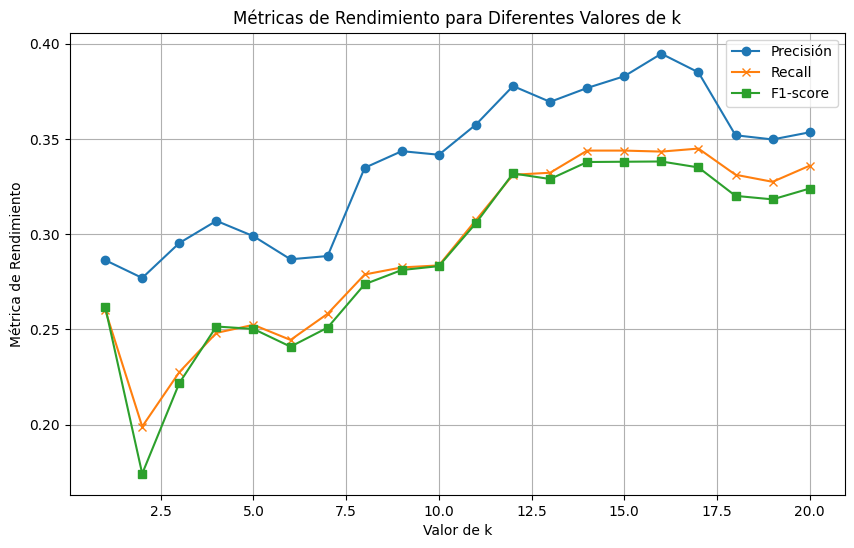

In [11]:
# Graficamos la precision promedio de las predicciones
k_values = range(1, 21)
# Después de calcular las métricas, fuera del bucle
plt.figure(figsize=(10, 6))  # Ajusta el tamaño de la figura

# Graficar la precisión
plt.plot(k_values, performance_metrics, label='Precisión', marker='o')

# Graficar el recall
plt.plot(k_values, recall_metrics, label='Recall', marker='x')

# Graficar el F1-score
plt.plot(k_values, f1_metrics, label='F1-score', marker='s')

# Añadir una leyenda para identificar las métricas
plt.legend()

# Etiquetas de los ejes y título
plt.xlabel('Valor de k')
plt.ylabel('Métrica de Rendimiento')
plt.title('Métricas de Rendimiento para Diferentes Valores de k')

# Mostrar la gráfica
plt.grid(True)  # Agregar una cuadrícula
plt.show()

Podemos concluir viendo la gráfica que el mejor valor de K es 18 porque es ahi donde obtenemos la mejor presición, Recall y F1-Score. Entonces a partir de ese K realizaremos nuestro reporte y confussion matrix.

#### Confusion Matrix y reporte general

In [39]:
best_k = 16
y_pred = knn_multiple(x_train, y_train, x_test, best_k)
confusion = confusion_matrix(y_test, y_pred)
print("Confusión Matrix para el mejor k:")
print(confusion)

Confusión Matrix para el mejor k:
[[ 2  0  0  1  0  0  2  0  1  2]
 [ 1  5  0  1  0  1  4  0  0  0]
 [ 1  0  4  0  2  0  1  0  0  0]
 [ 0  0  0  4  4  1  2  1  0  0]
 [ 1  0  0  0  5  0  0  4  0  1]
 [ 4  1  0  1  2  6  7  0  1  0]
 [ 0  2  0  1  2  0  5  1  0  0]
 [ 0  1  0  0  0  1  2 10  0  0]
 [ 2  0  0  1  6  2  0  0  0  2]
 [ 3  0  2  2  3  1  0  0  0  2]]


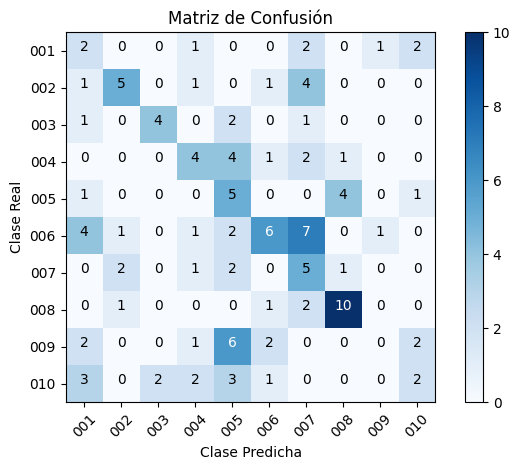

[[ 2  0  0  1  0  0  2  0  1  2]
 [ 1  5  0  1  0  1  4  0  0  0]
 [ 1  0  4  0  2  0  1  0  0  0]
 [ 0  0  0  4  4  1  2  1  0  0]
 [ 1  0  0  0  5  0  0  4  0  1]
 [ 4  1  0  1  2  6  7  0  1  0]
 [ 0  2  0  1  2  0  5  1  0  0]
 [ 0  1  0  0  0  1  2 10  0  0]
 [ 2  0  0  1  6  2  0  0  0  2]
 [ 3  0  2  2  3  1  0  0  0  2]]


In [40]:
confusion = confusion_matrix(y_test, y_pred)

# Define las etiquetas de las clases
classes = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "010"]  # Clases negativa y positiva

# Crea la figura y los ejes
plt.figure()
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Etiqueta los valores en la matriz
thresh = confusion.max() / 2.
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > thresh else "black")

plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.tight_layout()
plt.show()

print(confusion)

##### Reporte General

In [56]:
# Genera el informe de clasificación
report = classification_report(y_test, y_pred, output_dict=True)

# Convierte el informe en una cadena de texto
report_str = classification_report(y_test, y_pred)

# Imprime el informe en la consola
print("Informe de clasificación para el mejor valor de k:")
print(report_str)

# Guarda el informe como un archivo de texto
with open('classification_report.txt', 'w', encoding='utf-8') as f:
    f.write(report_str)


Informe de clasificación para el mejor valor de k:
              precision    recall  f1-score   support

         001       0.14      0.25      0.18         8
         002       0.56      0.42      0.48        12
         003       0.67      0.50      0.57         8
         004       0.36      0.33      0.35        12
         005       0.21      0.45      0.29        11
         006       0.50      0.27      0.35        22
         007       0.22      0.45      0.29        11
         008       0.62      0.71      0.67        14
         009       0.00      0.00      0.00        13
         010       0.29      0.15      0.20        13

    accuracy                           0.35       124
   macro avg       0.36      0.35      0.34       124
weighted avg       0.37      0.35      0.34       124



In [55]:
np.random.seed(123)
index = np.arange(len(dataset['labels']))
rnd = np.random.RandomState(123)
suffle_index = rnd.permutation(index)

x_shuffle, y_shuffle = [], []
for i in range(len(suffle_index)):
    x_shuffle.append(dataset['indep'][suffle_index[i]])
    y_shuffle.append(dataset['labels'][suffle_index[i]])
x_shuffle = np.array(x_shuffle)
y_shuffle = np.array(y_shuffle)

train_size = int(len(x_shuffle) * 0.70)
test_size = int(len(x_shuffle) * 0.15)
val_size = int(len(x_shuffle) * 0.15)

# Dividimos el dataset en train, test y validation
x_train = x_shuffle[:train_size]
y_train = y_shuffle[:train_size]

x_test = x_shuffle[train_size:train_size + test_size]
y_test = y_shuffle[train_size:train_size + test_size]

x_val = x_shuffle[train_size + test_size:]
y_val = y_shuffle[train_size + test_size:]

# Entrenamos el modelo con el mejor valor de k
best_k = 16
y_pred = knn_multiple(x_train, y_train, x_test, best_k)

# Calculamos la precisión de las predicciones
accuracy = precision_score(y_test, y_pred, average='weighted', zero_division=0)
print("Precisión de las predicciones:")
print(accuracy)

# Calculamos el recall y el F1-score
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print("Recall:")
print(recall)
print("F1-score:")
print(f1)

Precisión de las predicciones:
0.3681754051231611
Recall:
0.3467741935483871
F1-score:
0.33863196177361676
